In [2]:
%matplotlib inline
# import functions from python directory
import sys
sys.path.append("/home/bgreene/SBL_LES/python/")
import seaborn
import cmocean
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
from matplotlib import rc
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MultipleLocator
from LESnc import load_full, load_timeseries

In [3]:
# plotting setup
rc('font',weight='normal',size=20,family='serif',serif='Times New Roman')
rc('text',usetex='True')
rc('figure',facecolor='white')
cmap = seaborn.color_palette("Spectral", as_cmap=True)
cmap2 = seaborn.color_palette("cubehelix_r", as_cmap=True)

In [4]:
# directories
# figure save
figdir = "/home/bgreene/abl_transition/figures/AGU22/"
# list of simulations to loop over
sims = ["agu_1", "agu_2", "agu_3", "agu_4"]
# empty list to construct paths and store
dnc_all = []
for sim in sims:
    dnc = f"/home/rfrost/sim_output/linear_flux/{sim}/"
    dnc_all.append(dnc)

# Load timeseries from virtual tower data and calc some stats to plot

In [5]:
# load agu_1 data
d1 = xr.open_dataset(dnc_all[0]+"timeseries_all.nc")

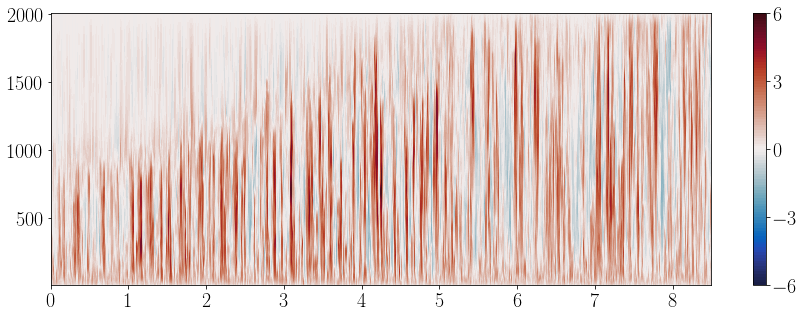

In [6]:
levelw = np.linspace(-6, 6, 101)
fig, ax = plt.subplots(1, figsize=(14.8, 5))
cfax = ax.contourf(d1.t/3600, d1.z, d1.w.T, cmap=cmocean.cm.balance, levels=levelw)
fig.colorbar(cfax, ax=ax, location="right", ticks=MultipleLocator(3))

In [7]:
# calculate 1-min "fluxes"
# calculate 1-min block means of u,v,w,theta
t_bin = np.arange(0, d1.t[-1]+1, 60)
t_bin_mid = (t_bin[0:-1] + t_bin[1:]) / 2

for v in ["u", "v", "w", "theta"]:
    # calculate and store mean of each block
    blocks = d1[v].groupby_bins("t", t_bin, labels=t_bin_mid)
    d1[f"{v}_mean"] = blocks.mean("t")
    # calculate perturbations in each block
    d1[f"{v}_pert"] = blocks - d1[f"{v}_mean"]

# calculate "inst" covars
d1["uw"] = d1.u_pert * d1.w_pert + d1.txz
d1["vw"] = d1.v_pert * d1.w_pert + d1.tyz
d1["tw"] = d1.theta_pert * d1.w_pert + d1.q3

# calculate "inst" vars
d1["uu"] = d1.u_pert * d1.u_pert
d1["vv"] = d1.v_pert * d1.v_pert
d1["ww"] = d1.w_pert * d1.w_pert
d1["tt"] = d1.theta_pert * d1.theta_pert

# average "inst" covars and vars in 1-min blocks
for v in ["uw", "vw", "tw", "uu", "vv", "ww", "tt"]:
    d1[f"{v}_1min"] = d1[v].groupby_bins("t", t_bin, labels=t_bin_mid).mean("t")

# TKE
d1["TKE_1min"] = 0.5 * (d1.uu_1min + d1.vv_1min + d1.ww_1min)

In [30]:
# load average_statistics_tz.nc for timesereis of stats
s1 = xr.load_dataset(dnc_all[0]+"649000_1152000_average_statistics_tz.nc")
s1["time"] = s1["time"] + 50.

In [31]:
# plot linear overlay of sfc heat flux
# case 1
Q1 = np.array([0.10, 0.10, 0.25, 0.25, 0.10, 0.10])
tQ1 = np.array([0.0, 0.5, 1.5, 4.5, 5.5, 8.5]) + 9

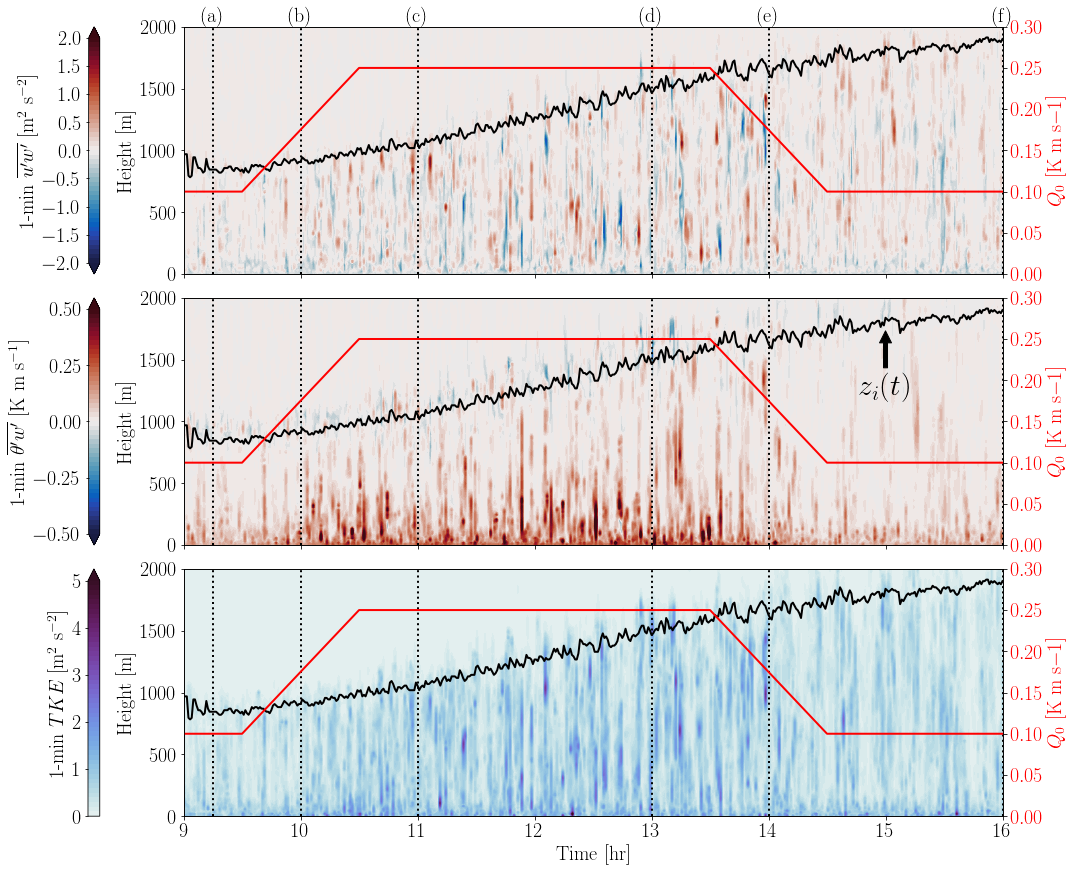

In [60]:
# u'w', theta'w', TKE on one figure
# define figure
fig1, ax1 = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=True,
                         constrained_layout=True, figsize=(14.8, 12))
# color limits
leveluw = np.linspace(-2, 2, 51)
leveltw = np.linspace(-0.5, 0.5, 51)
levele = np.linspace(0, 5, 51)
# contour uw
cfax11 = ax1[0].contourf(9+d1.t_bins/3600, d1.z, d1.uw_1min.T, extend="both",
                         levels=leveluw, cmap=cmocean.cm.balance)
# contour tw
cfax12 = ax1[1].contourf(9+d1.t_bins/3600, d1.z, d1.tw_1min.T, extend="both",
                         levels=leveltw, cmap=cmocean.cm.balance)
# contour TKE
cfax13 = ax1[2].contourf(9+d1.t_bins/3600, d1.z, d1.TKE_1min.T, extend="max",
                         levels=levele, cmap=cmocean.cm.dense)
# plot zi timeseries
for iax in ax1:
    iax.plot(9+s1.time/3600., s1.zi, ls="-", c="k", lw=2)

# 2nd y-axis for sfc heat flux on each axis
for iax in ax1:
    ax1_2 = iax.twinx()
    ax1_2.plot(tQ1, Q1, c="r", lw=2, ls="-")
    # axis limits and labels
    ax1_2.set_ylim([0, 0.3])
    ax1_2.set_ylabel("$Q_0$ [K m s${-1}$]", color="red")
    ax1_2.tick_params(axis="y", labelcolor="red")
# colorbars
cb11 = fig1.colorbar(cfax11, ax=ax1[0], location="left", ticks=MultipleLocator(0.5), pad=0.02)
cb12 = fig1.colorbar(cfax12, ax=ax1[1], location="left", ticks=MultipleLocator(0.25), pad=0.02)
cb13 = fig1.colorbar(cfax13, ax=ax1[2], location="left", ticks=MultipleLocator(1), pad=0.02)
# colorbar labels
cb11.ax.set_ylabel("1-min $\\overline{u'w'}$ [m$^2$ s$^{-2}$]")
cb12.ax.set_ylabel("1-min $\\overline{\\theta'w'}$ [K m s$^{-1}$]")
cb13.ax.set_ylabel("1-min $TKE$ [m$^2$ s$^{-2}$]")
# axis limits
ax1[0].set_xlim([9, 16])
ax1[0].set_ylim([0, 2000])
# axis labels
ax1[-1].set_xlabel("Time [hr]")
for iax in ax1:
    iax.set_ylabel("Height [m]")
# vertical dashed lines for xy, xz cross-section analysis times
# array of times
tcross = np.array([0.25, 1.0, 2.0, 4.0, 5.0, 7.0]) + 9. # hrs
for iax in ax1:
    [iax.axvline(tt, c="k", ls=":", lw=2) for tt in tcross]
# text labels above dotted lines
for tt, lab in zip(tcross, list("abcdef")):
    ax1[0].text(tt, 2000, f"({lab})", fontsize=20, ha="center", va="bottom")
# annotate plot of zi
ax1[1].annotate("$z_i(t)$", xy=(15, 1750),  xycoords="data",
                xytext=(15, 1400), textcoords="data", fontsize=30,
                arrowprops=dict(facecolor="black", shrink=0.05),
                horizontalalignment="center", verticalalignment="top")
# save figure
fsave = f"{figdir}agu1_timeheight.png"
fig1.savefig(fsave, dpi=900)

# Do all the same for case 2

In [11]:
d2 = xr.open_dataset(dnc_all[1]+"timeseries_all.nc")

In [28]:
# load average_statistics_tz.nc for timesereis of stats
s2 = xr.load_dataset(dnc_all[1]+"649000_1260000_average_statistics_tz.nc")
s1["time"] = s1["time"] + 50.

In [12]:
# calculate 1-min "fluxes"
# calculate 1-min block means of u,v,w,theta
t_bin = np.arange(0, d2.t[-1]+1, 60)
t_bin_mid = (t_bin[0:-1] + t_bin[1:]) / 2

for v in ["u", "v", "w", "theta"]:
    # calculate and store mean of each block
    blocks = d2[v].groupby_bins("t", t_bin, labels=t_bin_mid)
    d2[f"{v}_mean"] = blocks.mean("t")
    # calculate perturbations in each block
    d2[f"{v}_pert"] = blocks - d2[f"{v}_mean"]

# calculate "inst" covars
d2["uw"] = d2.u_pert * d2.w_pert + d2.txz
d2["vw"] = d2.v_pert * d2.w_pert + d2.tyz
d2["tw"] = d2.theta_pert * d2.w_pert + d2.q3

# calculate "inst" vars
d2["uu"] = d2.u_pert * d2.u_pert
d2["vv"] = d2.v_pert * d2.v_pert
d2["ww"] = d2.w_pert * d2.w_pert
d2["tt"] = d2.theta_pert * d2.theta_pert

# average "inst" covars and vars in 1-min blocks
for v in ["uw", "vw", "tw", "uu", "vv", "ww", "tt"]:
    d2[f"{v}_1min"] = d2[v].groupby_bins("t", t_bin, labels=t_bin_mid).mean("t")

# TKE
d2["TKE_1min"] = 0.5 * (d2.uu_1min + d2.vv_1min + d2.ww_1min)

In [13]:
# plot linear overlay of sfc heat flux
# case 2
Q2 = np.array([0.10, 0.10, 0.25, 0.25, 0.10, 0.10])
tQ2 = np.array([0.0, 0.5, 1.0, 4.0, 4.5, 8.5]) + 9.

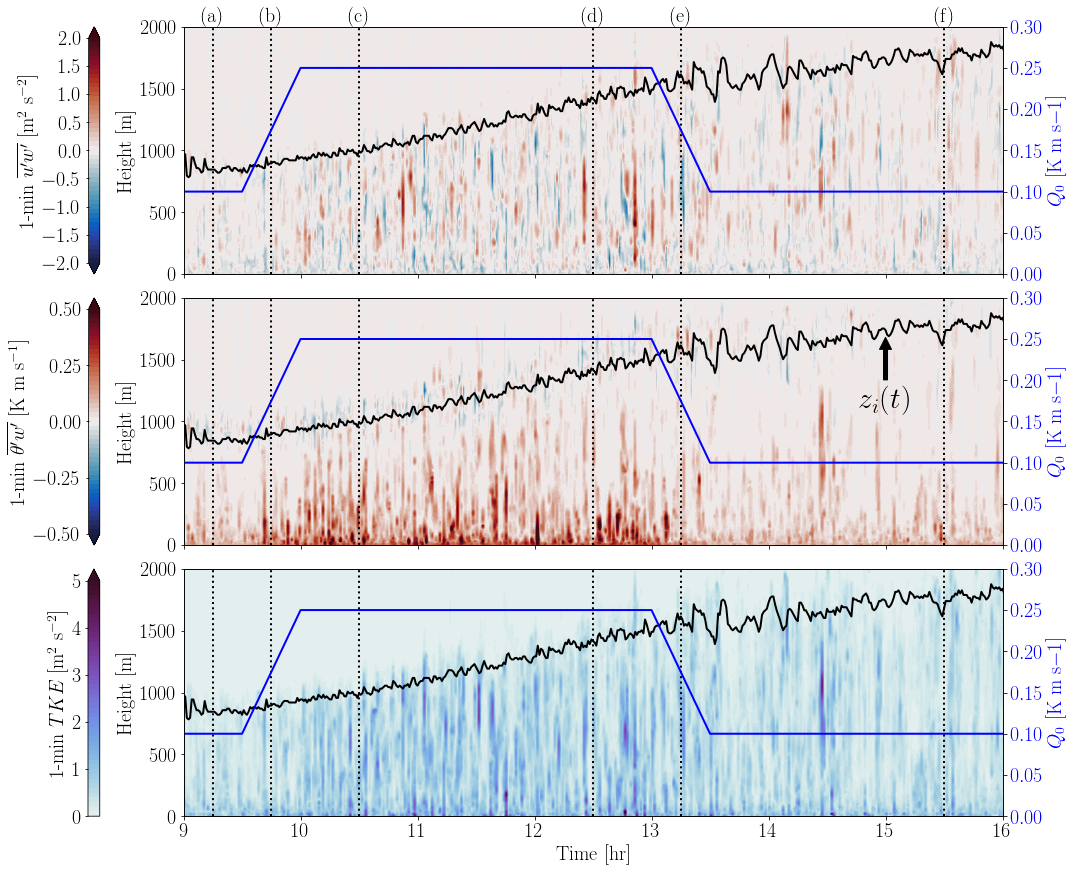

In [61]:
# u'w', theta'w', TKE on one figure
# define figure
fig2, ax2 = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=True,
                         constrained_layout=True, figsize=(14.8, 12))
# color limits
leveluw = np.linspace(-2, 2, 51)
leveltw = np.linspace(-0.5, 0.5, 51)
levele = np.linspace(0, 5, 51)
# contour uw
cfax21 = ax2[0].contourf(9+d2.t_bins/3600, d2.z, d2.uw_1min.T, extend="both",
                         levels=leveluw, cmap=cmocean.cm.balance)
# contour tw
cfax22 = ax2[1].contourf(9+d2.t_bins/3600, d2.z, d2.tw_1min.T, extend="both",
                         levels=leveltw, cmap=cmocean.cm.balance)
# contour TKE
cfax23 = ax2[2].contourf(9+d2.t_bins/3600, d2.z, d2.TKE_1min.T, extend="max",
                         levels=levele, cmap=cmocean.cm.dense)
# plot zi timeseries
for iax in ax2:
    iax.plot(9+s2.time/3600., s2.zi, ls="-", c="k", lw=2)
# 2nd y-axis for sfc heat flux on each axis
for iax in ax2:
    ax2_2 = iax.twinx()
    ax2_2.plot(tQ2, Q2, c="b", lw=2, ls="-")
    # axis limits and labels
    ax2_2.set_ylim([0, 0.3])
    ax2_2.set_ylabel("$Q_0$ [K m s${-1}$]", color="b")
    ax2_2.tick_params(axis="y", labelcolor="b")
# colorbars
cb21 = fig2.colorbar(cfax21, ax=ax2[0], location="left", ticks=MultipleLocator(0.5), pad=0.02)
cb22 = fig2.colorbar(cfax22, ax=ax2[1], location="left", ticks=MultipleLocator(0.25), pad=0.02)
cb23 = fig2.colorbar(cfax23, ax=ax2[2], location="left", ticks=MultipleLocator(1), pad=0.02)
# colorbar labels
cb21.ax.set_ylabel("1-min $\\overline{u'w'}$ [m$^2$ s$^{-2}$]")
cb22.ax.set_ylabel("1-min $\\overline{\\theta'w'}$ [K m s$^{-1}$]")
cb23.ax.set_ylabel("1-min $TKE$ [m$^2$ s$^{-2}$]")
# axis limits
ax2[0].set_xlim([9, 16])
ax2[0].set_ylim([0, 2000])
# axis labels
ax2[-1].set_xlabel("Time [hr]")
for iax in ax2:
    iax.set_ylabel("Height [m]")
# vertical dashed lines for xy, xz cross-section analysis times
# array of times
tcross = np.array([0.25, 0.75, 1.5, 3.5, 4.25, 6.5]) + 9. # hrs
for iax in ax2:
    [iax.axvline(tt, c="k", ls=":", lw=2) for tt in tcross]
# text labels above dotted lines
for tt, lab in zip(tcross, list("abcdef")):
    ax2[0].text(tt, 2000, f"({lab})", fontsize=20, ha="center", va="bottom")
# annotate plot of zi
ax2[1].annotate("$z_i(t)$", xy=(15, 1700),  xycoords="data",
                xytext=(15, 1300), textcoords="data", fontsize=30,
                arrowprops=dict(facecolor="black", shrink=0.05),
                horizontalalignment="center", verticalalignment="top")
# save figure
fsave = f"{figdir}agu2_timeheight.png"
fig2.savefig(fsave, dpi=900)